In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

from stein_thinning.thinning import thin

import lotka_volterra
import utils.caching
from utils.caching import make_cached_s3
from utils.parallel import get_map_parallel_joblib
from utils.paths import FIGURES_PATH, S3_BUCKET_NAME
from utils.plotting import plot_sample_thinned

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [5]:
cached = make_cached_s3(S3_BUCKET_NAME)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

Read-only input datasets:

In [7]:
@cached(item_type=np.ndarray, batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplementedError

In [8]:
@cached(item_type=np.ndarray, batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_samples() -> list[np.ndarray]:
    raise NotImplementedError

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_grads(i: int) -> np.ndarray:
    raise NotImplementedError

In [10]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_grads(i: int) -> np.ndarray:
    raise NotImplementedError

# Apply Stein thinning

### Random-walk sample

In [11]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

In [12]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_thinned_idx(i) -> np.ndarray:
    return thin(np.exp(rw_samples[i]), rw_grads[i], n_points_calculate, preconditioner='med')

Force recalculation when necessary:

In [13]:
%%time
map_parallel(rw_thinned_idx.get_or_recalculate, range(lotka_volterra.n_chains));

CPU times: user 38.6 ms, sys: 58.3 ms, total: 96.9 ms
Wall time: 2.54 s


#### Log-transformation

Since inference is performed in log-space, it is natural to try Stein thinning in log-space as well.

If $\xi_i = \log \theta_i$, then by the chain rule we have
$$\frac{\partial f}{\partial \xi_i} = \sum_{j=1}^d \frac{\partial f}{\partial \theta_j} \frac{\partial \theta_j}{\partial \xi_i},$$
thus
$$\nabla_{\pmb{\xi}} \log p(\pmb{\xi}) = J^{-T} \nabla_{\pmb{\theta}} \log p(\pmb{\theta}),$$
where the Jacobian is $J = \text{diag}(\theta_1^{-1}, \dots, \theta_d^{-1})$, so $J^{-T} =  \text{diag}(\theta_1, \dots, \theta_d)$.

In [14]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_st_log_idx(i) -> np.ndarray:
    return thin(rw_samples[i], np.exp(rw_samples[i]) * rw_grads[i], n_points_calculate, preconditioner='med')

Force recalculation when necessary:

In [15]:
%%time
map_parallel(rw_st_log_idx.get_or_recalculate, range(lotka_volterra.n_chains));

CPU times: user 14.9 ms, sys: 240 μs, total: 15.2 ms
Wall time: 116 ms


This reproduces the results shown in Figure S20 in the Supplementary Material:

In [16]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_st_log_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_st_log_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_st_log_idx_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_st_log_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_3.npy
DEBUG:utils.caching:Rea

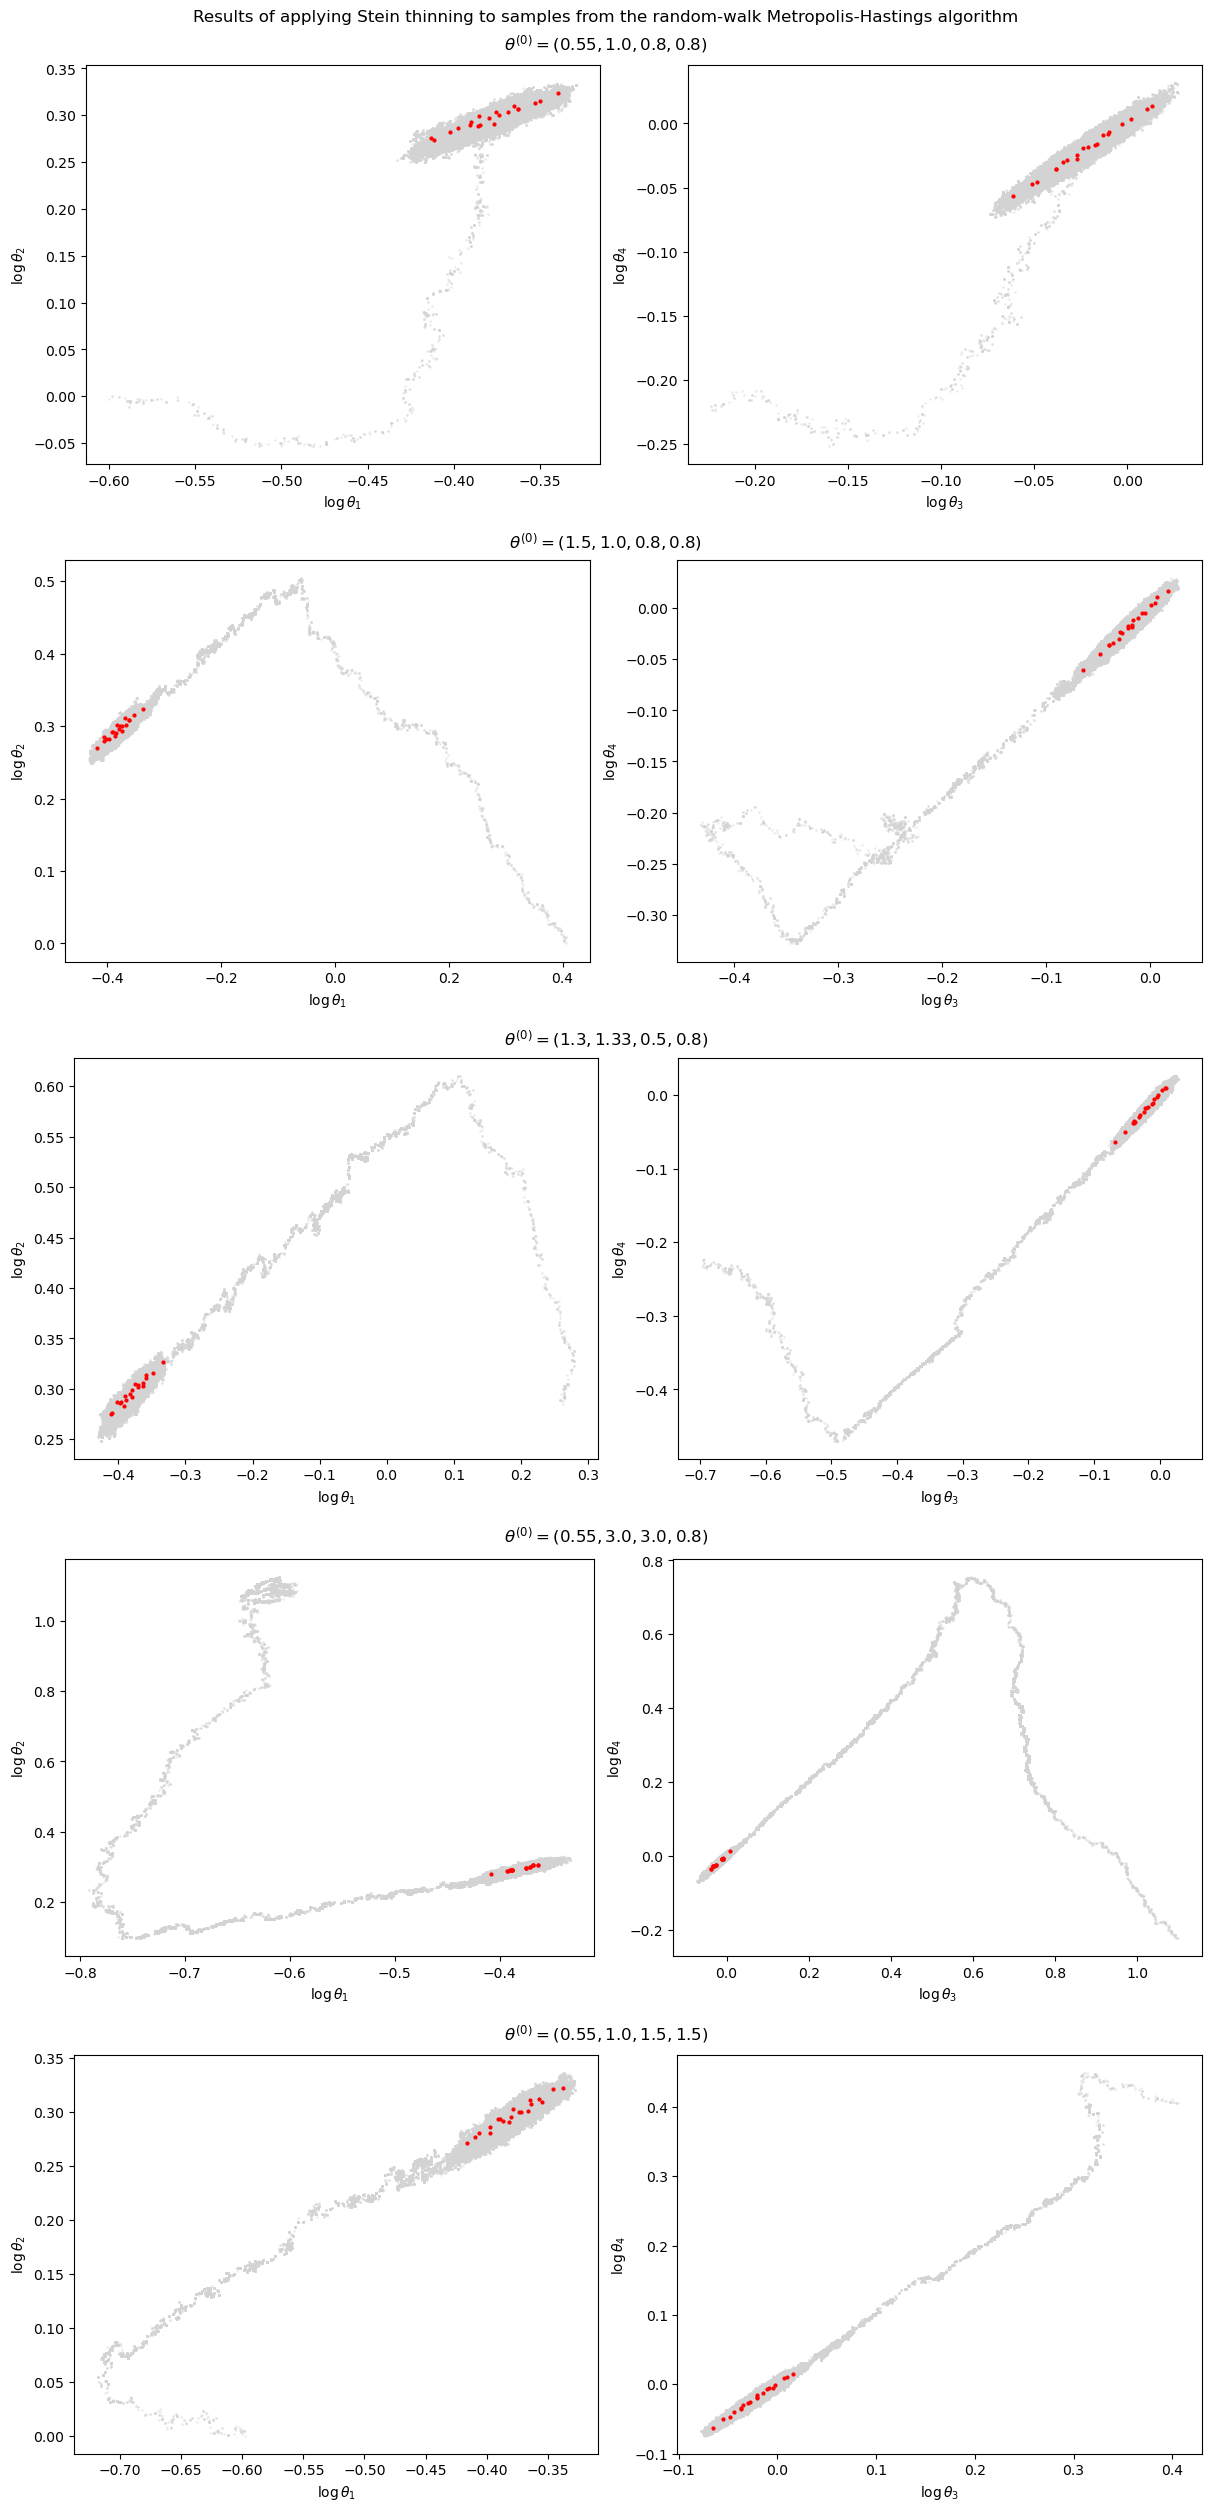

In [17]:
fig = plot_sample_thinned(rw_samples, rw_st_log_idx, titles, var_labels, n_points=n_points_display);
fig.savefig(FIGURES_PATH / 'lotka-volterra-stein-thinning.png', dpi=300);
fig.suptitle('Results of applying Stein thinning to samples from the random-walk Metropolis-Hastings algorithm');

### HMC sample

In [18]:
@cached()
def hmc_thinned_idx(i: int) -> np.ndarray:
    return thin(np.exp(hmc_samples[i]), hmc_grads[i], n_points_thinned, preconditioner='med')

DEBUG:utils.caching:Reading from disk cache: hmc_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_3.npy
DEB

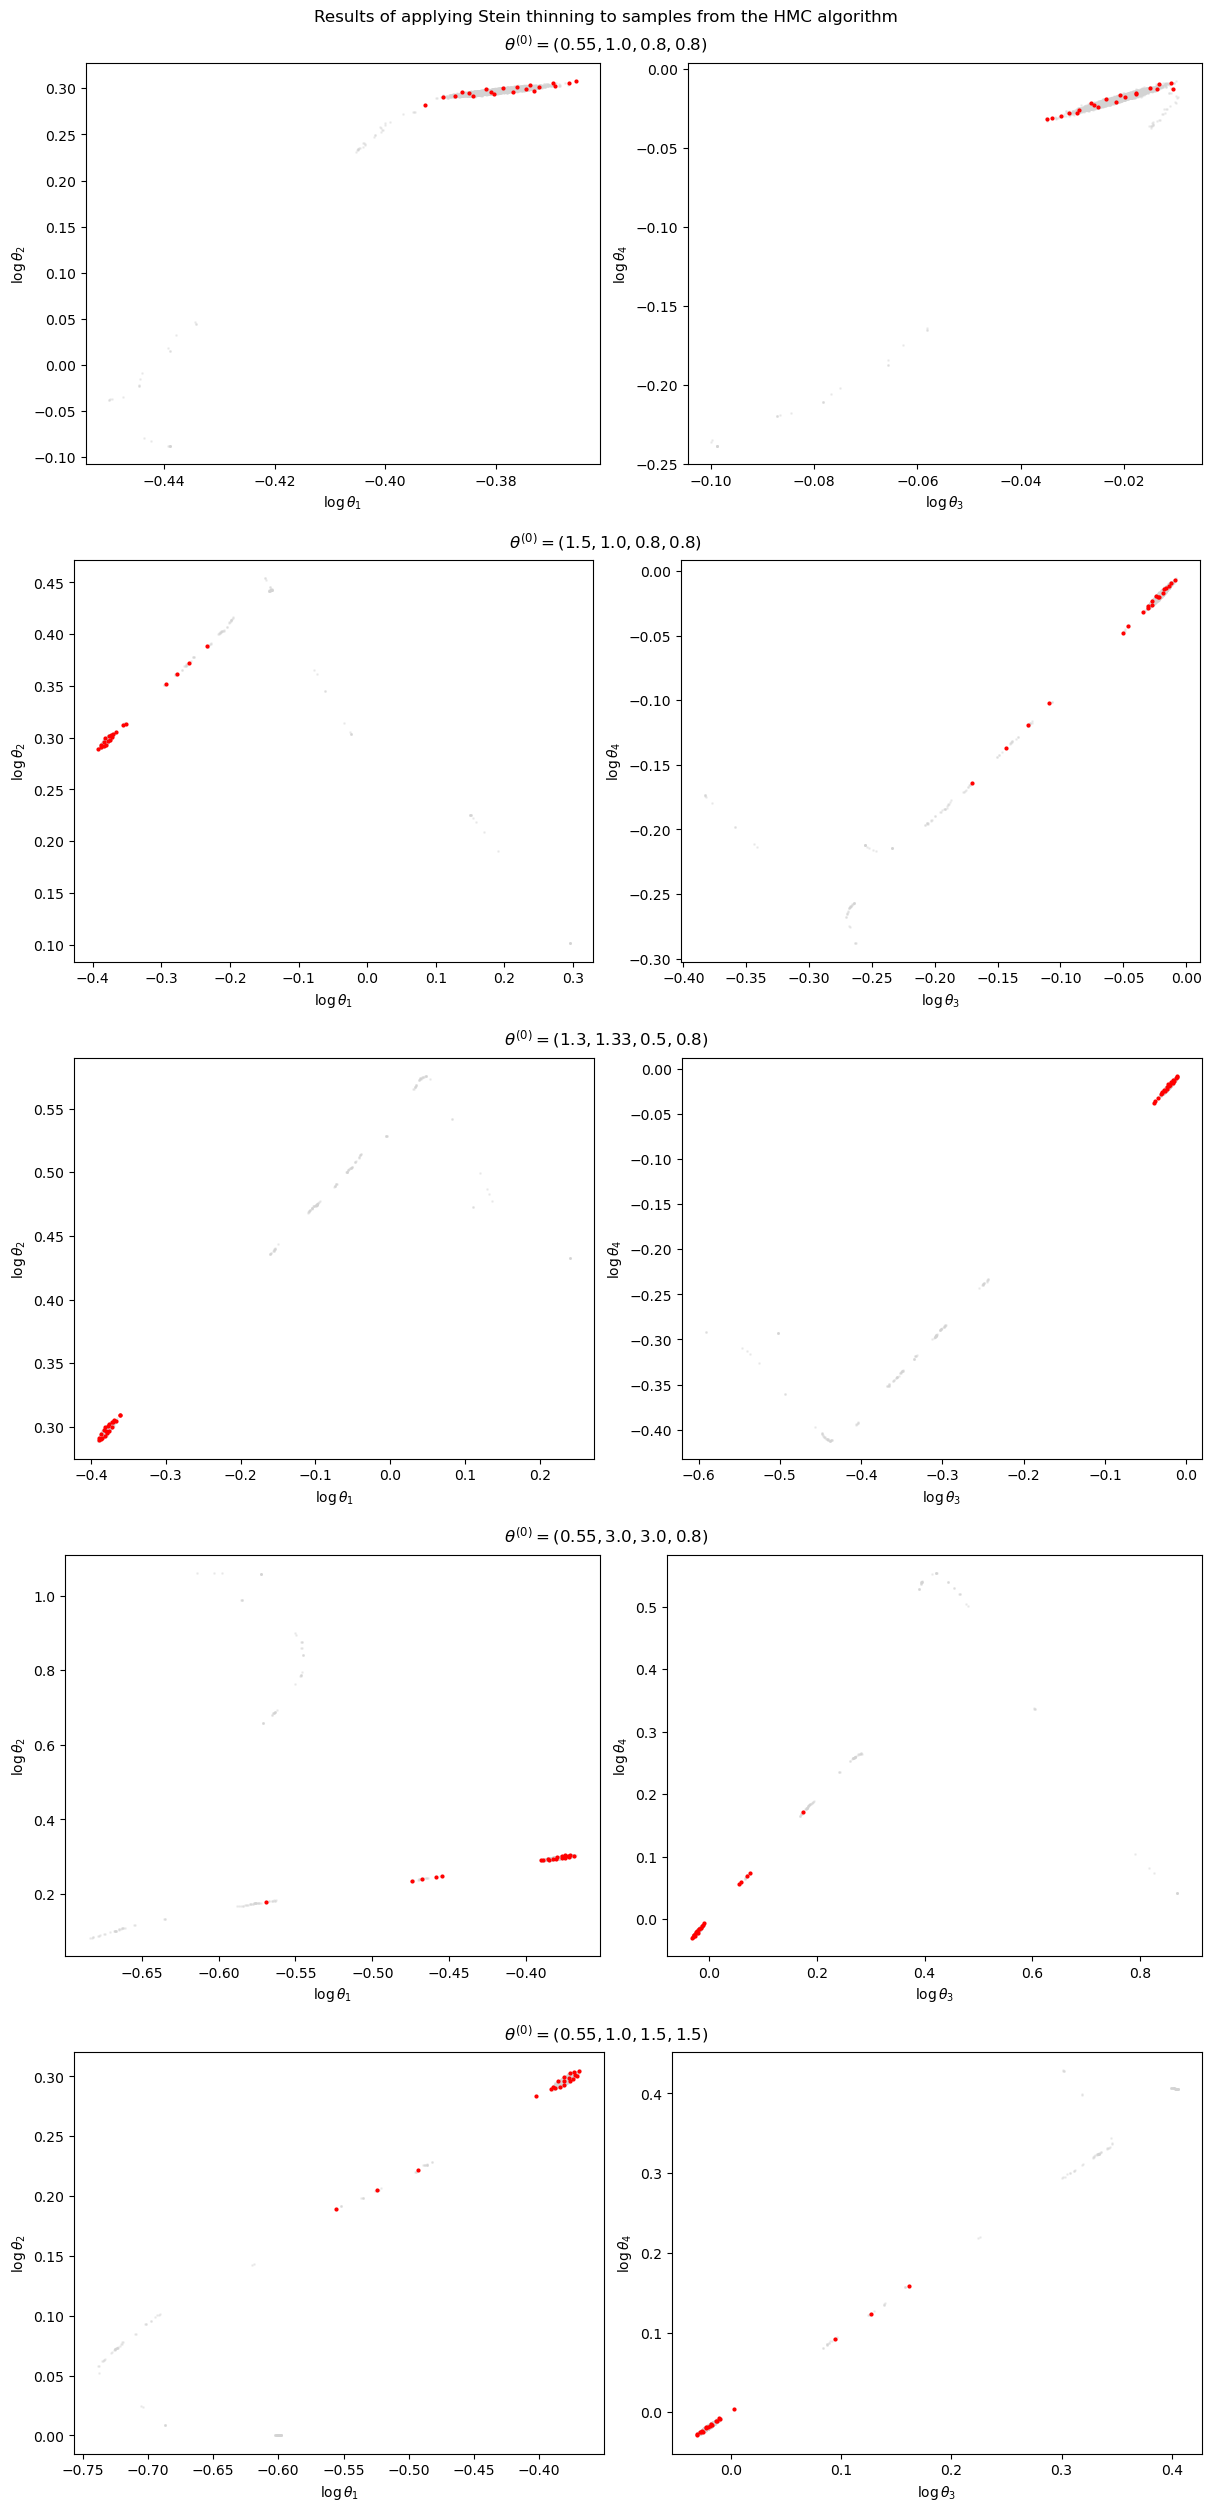

In [19]:
fig = plot_sample_thinned(hmc_samples, hmc_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the HMC algorithm');

In [20]:
time.time() - start_time

26.785101175308228